## Below the steps to identify the most promising stocks using the EPS X appraoch

1. have an excel file with all the tickers extracted from a filter on tradingview
2. Compute the FP (see below) for all the companies
3. Compute PFV (see below) for the all the companies
4. Create a flag column "below eps_pfv" indicating whether the price is below pfv
5. take the tickers respecting the condition 4 and create history plots
6. select by hand the most promising stocks
7. for the selected ones get the price to pfv ratio
8. do an ascending sort of the stocks with the values computed in 7 and see the most promising tickers

### Formula

* $FP = EPS \cdot (1 + Growth)^{Years} \cdot PE$

* $PFV = \frac{FP}{(1 + Return)^{Years}}$

In the equations : 

* `FP` means *Future Price* and refers to the price that the stock should have in the future
* `PFV` mean *Present Fair Value* and refers to the price that the company should be trading today in the market
* `EPS` refers to the EPS that we see of the company today (now, avg TTM, MRQ, etc)
* `Growth` refers to what I think the company is going to grow in the following years
* `Years` are the number of years to take into consideration when doing the calculation
* `PE` refers to what I think is going to be the PE ratio after all the years considered. Thus, this is an estimated future PE ratio
* `Return` refers to what I think is going to be the avg yearly return of the investment during all the years considered

### Imports

In [1]:
import certifi
import ssl
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import requests
from urllib.request import urlopen, Request
from datetime import timedelta
from typing import List, Any, Tuple, Dict

### Constants

In [2]:
current_assets_factors = {
    "receivables_factor": 0.8,
    "inventory_factor": 0.6,
    "ppe_factor": 0.67,
}

bs_cols = [
    "fillingDate",
    "symbol",
    "totalEquity",
    "totalCurrentAssets",
    "totalAssets",
    "totalCurrentLiabilities", 
    "totalLiabilities",
    "totalStockholdersEquity",
    "totalDebt",
    "goodwillAndIntangibleAssets",
    "goodwill",
    "intangibleAssets",
]
is_cols = [
    "fillingDate",
    "eps",
    "weightedAverageShsOutDil",
    "revenue",
    "netIncome",
    
]

### Functions

In [3]:
def compute_fp(
    eps:float,
    growth_value: float,
    years: int,
    future_pe: float,
) -> float:
    capped_growth_value = min(0.40, growth_value)
    capped_future_pe = min(20, future_pe)
    return eps * ((1 + capped_growth_value) ** years) * capped_future_pe

def compute_pfv(fp: float, return_value: float, years: int) -> float:
    capped_return_value = min(0.20, return_value)
    return fp / ((1 + capped_return_value) ** years)

def compute_pex_value_handler(
    eps: float,
    growth_value: float,
    return_value: float,
    future_pe: float,
    years: int,
) -> float:
    fp = compute_fp(eps, growth_value, years, future_pe)
    pfv = compute_pfv(fp, return_value, years)
    return pfv

In [4]:
def get_income_stmt_info(ticker: str, nb_years: int = 10) -> List[Dict[str, Any]]:
    url_income_stmt = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit={nb_years}&apikey={KEY}"
    #response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
    context = ssl.create_default_context(cafile=certifi.where())
    response_income_stmt = urlopen(Request(url_income_stmt), context=context)
    data_income_stmt = response_income_stmt.read().decode("utf-8")
    data_income_stmt = json.loads(data_income_stmt)
    return data_income_stmt

def get_balance_sheet_info(ticker: str, nb_years: int = 10) -> List[Dict[str, Any]]:
    url_balance_sheet = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?limit={nb_years}&apikey={KEY}"
    #response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())
    context = ssl.create_default_context(cafile=certifi.where())
    response_balance_sheet = urlopen(Request(url_balance_sheet), context=context)
    data_balance_sheet = response_balance_sheet.read().decode("utf-8")
    data_balance_sheet = json.loads(data_balance_sheet)
    return data_balance_sheet

def get_key_from_iterator(iterator: List[Dict[str, Any]], key: str) -> List[float]:
    all_eps = [element[key] for element in iterator]
    return all_eps

def compute_historical_growth(iterator: List[float]) -> List[float]:
    all_growth = [np.nan]
    for idx in range(1, len(iterator)):
        all_growth.append((iterator[idx] - iterator[idx-1]) / (iterator[idx-1] + 1e-6))
    return all_growth

def drop_nans(iterator: List[float]) -> List[float]:
    iterator_wo_nans = [element for element in iterator if not np.isnan(element)]
    return iterator_wo_nans

def compute_stat_bound(
    iterator: List[float], q_inf: float = 0.25, q_sup: float = 0.75, distance: int = 3
) -> Tuple[float, float]:
    q1 = np.quantile(iterator, q_inf)
    q3 = np.quantile(iterator, q_sup)
    iqr = q3 - q1
    lower_bound = q1 - distance*iqr
    upper_bound = q3 + distance*iqr
    return lower_bound, upper_bound

def compute_avg_value(iterator: List[float]) -> float:
    return np.mean(iterator)

In [5]:
def get_reporting_window(financial_info: Dict[str, Any]) -> Tuple[str, str]:
    last_report_date = financial_info["date"]
    window_start = pd.to_datetime(last_report_date) + pd.DateOffset(days=30)
    window_start = str(window_start.date())
    window_end = pd.to_datetime(last_report_date) + pd.DateOffset(days=46)
    window_end = str(window_end.date())
    return window_start, window_end

# this is the new get_prices_in_range function
def get_prices_in_range(ticker: str, window_start: str, window_end: str) -> List[Dict[str, Any]]:
    url_prices =  f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?from={window_start}&to={window_end}&apikey={KEY}"
    #response_prices = urlopen(url_prices, cafile=certifi.where())
    context = ssl.create_default_context(cafile=certifi.where())
    response_prices = urlopen(Request(url_prices), context=context)
    data_prices = response_prices.read().decode("utf-8")
    data_prices = json.loads(data_prices)
    return data_prices

def handling_negative_pe(iterator: List[float]) -> List[float]:
    positive_historical_pe = [val if val > 0 else 0 for val in iterator]
    return positive_historical_pe

In [6]:
def get_current_price(ticker):
    url_price = f"https://financialmodelingprep.com/api/v3/quote/{ticker}?limit=1&apikey={KEY}"
    #response_price = urlopen(url_price, cafile=certifi.where())
    context = ssl.create_default_context(cafile=certifi.where())
    response_price = urlopen(Request(url_price), context=context)
    data_price = response_price.read().decode("utf-8")
    data_price = json.loads(data_price)
    print(data_price)
    if len(data_price) > 0:
        data_price = data_price[0]
        return data_price["price"]
    return None

### Constants

In [9]:
! ls

backtesting-exploration.ipynb
backtesting-output-analysis.ipynb
db-read-test.ipynb
delisted-companies-endpoint-test.ipynb
eps-x-calculation-example.ipynb
exchange-rates-api-exploration.ipynb
fmp-api-tests.ipynb
ncav-and-liqv-calculations.ipynb
tables-to-drop-for-new-execution.ipynb
various-tests-extraction-system-design.ipynb


In [10]:
KEY_PATH = "../fmi-personal-key.txt"
with open(KEY_PATH, "r") as f:
    KEY = f.read()

In [ ]:
with open("tickers_list_03092023.txt", "r") as f:
    TICKERS = f.read().split("\n")

In [ ]:
TICKERS = list(set(TICKERS))

In [ ]:
"CTHR" in TICKERS

Example of EPS X calculation for CTHR

There are 4 things that we need to decide to compute the value : 

* Return : I am going to use a standard of 20%
* Growth : I am going to use the data of the last 10 years and the what has been the avg growth. I am going to try it with EPS and then see if it's possible to do it with equity
* PE : The future PE ratio will be (10Y max - 10Ymin) / 2. I need to get the data from the last 10 years For the EPS it'll be straightforward, for the price I should match the eps of year X with the avg price of 3 months after the data of the report of year X
* Years : Number of years to consider in the calculations. I will use 7 (in between 5 and 10) cuz 5 is too short and 10 is too long

#### Return value

In [7]:
return_value = 0.2
return_value

0.2

#### Growth value

In [ ]:
# step by step

In [ ]:
ticker = "SSY"
url_income_stmt = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=10&apikey={KEY}"
response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
data_income_stmt = response_income_stmt.read().decode("utf-8")
data_income_stmt = json.loads(data_income_stmt)

url_balance_sheet = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?limit=10&apikey={KEY}"
response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())
data_balance_sheet = response_balance_sheet.read().decode("utf-8")
data_balance_sheet = json.loads(data_balance_sheet)

In [8]:
def get_income_stmt_info(ticker: str, nb_years: int = 10) -> List[Dict[str, Any]]:
    url_income_stmt = f"https://financialmodelingpr.com/api/v3/income-statement/{ticker}?"

    params = {
        "limit": nb_years,
        "apikey": KEY,
    }

    try:
        response = requests.get(url_income_stmt, params=params)
        response.raise_for_status()
        data_income_stmt = response.json()
        return data_income_stmt
    except requests.exceptions.RequestException as e:
        print(f"Request error: {e}")
    except json.JSONDecodeError as e:
        print(f"JSON decoding error: {e}")

In [ ]:
all_eps = [element["eps"] for element in data_income_stmt]
all_eps

In [ ]:
all_equity = [element["totalStockholdersEquity"] for element in data_balance_sheet]
all_equity

In [ ]:
all_growth = []
for idx in range(1, len(all_equity)):
    all_growth.append((all_equity[idx-1] - all_equity[idx]) / all_equity[idx])

In [ ]:
all_growth

In [ ]:
# Cap the extreme growth rates for a more conservative approach
# Not the extrem drops since it'll help put numbers down
q1 = np.quantile(all_growth, 0.25)
q3 = np.quantile(all_growth, 0.75)
iqr = q3 - q1
lower_bound = q1 - 3*iqr
upper_bound = q3 + 3*iqr

all_growth_wo_extremes = [min(element, upper_bound) for element in all_growth]# if lower_bound < element < upper_bound]
all_growth_wo_extremes

In [ ]:
lower_bound, upper_bound

In [ ]:
growth_value = np.mean(all_growth_wo_extremes)#np.mean(all_growth)

In [ ]:
growth_value

In [ ]:
growths = []
for nb_years in [5, 6, 7, 8, 9]:
    single_growth = (all_equity[0] / all_equity[nb_years-1]) ** (1/(nb_years-1)) - 1
    print(f"CAGR in {nb_years} years: {single_growth}")
    growths.append(single_growth)

In [ ]:
growth_5y = (all_equity[0] / all_equity[4]) ** (1/4) - 1
growth_10y = (all_equity[0] / all_equity[-1]) ** (1/9) - 1

(growth_5y + growth_10y) / 2, growth_5y, growth_10y, (all_equity[0] / all_equity[-4]) ** (1/6)

In [ ]:
# using methods

In [ ]:
ticker = "CTHR"
data_income_stmt = get_income_stmt_info(ticker=ticker, nb_years=10)
#all_eps = get_key_from_iterator(iterator=data_income_stmt, key="eps")
all_equity = get_key_from_iterator(iterator=data_balance_sheet, key="totalStockholdersEquity")
#all_growth = compute_historical_growth(all_eps)
all_growth = compute_historical_growth(all_equity)
growth_5y = (all_equity[0] / all_equity[4]) ** (1/4) - 1
growth_10y = (all_equity[0] / all_equity[-1]) ** (1/9) - 1
growth_value = (growth_5y + growth_10y) / 2
growths = []
for nb_years in [5, 6, 7, 8, 9]:
    single_growth = (all_equity[0] / all_equity[nb_years-1]) ** (1/(nb_years-1)) - 1
    growths.append(single_growth)
growth_value = np.median(growths)
growth_value

#### Future PE

In [ ]:
# The reporting of a period is expected between 30 - 45 days after the ending of that period
all_prices = []
for single_income_stmt in data_income_stmt:
    reporting_window_start = pd.to_datetime(single_income_stmt["date"]) + pd.DateOffset(days=30)
    reporting_window_start = str(reporting_window_start.date())
    reporting_window_end = pd.to_datetime(single_income_stmt["date"]) + pd.DateOffset(days=46)
    reporting_window_end = str(reporting_window_end.date())
    
    url_prices =  f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?from={reporting_window_start}&to={reporting_window_end}&apikey={KEY}"
    response_prices = urlopen(url_prices, cafile=certifi.where())
    data_prices = response_prices.read().decode("utf-8")
    data_prices = json.loads(data_prices)
    
    price_at_report = np.mean([element["low"] for element in data_prices["historical"]])
    
    all_prices.append(price_at_report)

In [ ]:
all_prices

In [ ]:
# I don't like a pe of zero cuz we mask very big drops that could hide info
historical_pe = list(np.array(all_prices) / np.array(all_eps))
historical_pe = [val if val > 0 else 0 for val in historical_pe]
historical_pe

In [ ]:
future_pe = np.mean(historical_pe)

In [ ]:
future_pe

In [9]:
def get_reporting_window(financial_info: Dict[str, Any]) -> Tuple[str, str]:
    last_report_date = financial_info["date"]
    window_start = pd.to_datetime(last_report_date) + pd.DateOffset(days=30)
    window_start = str(window_start.date())
    window_end = pd.to_datetime(last_report_date) + pd.DateOffset(days=46)
    window_end = str(window_end.date())
    return window_start, window_end

# this is the old get_prices_in_range function
"""def get_prices_in_range(ticker: str, window_start: str, window_end: str) -> List[Dict[str, Any]]:
    url_prices =  f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?from={window_start}&to={window_end}&apikey={KEY}"
    response_prices = urlopen(url_prices, cafile=certifi.where())
    data_prices = response_prices.read().decode("utf-8")
    data_prices = json.loads(data_prices)
    return data_prices"""

def handling_negative_pe(iterator: List[float]) -> List[float]:
    positive_historical_pe = [val if val > 0 else 0 for val in iterator]
    return positive_historical_pe

In [ ]:
# using methods

In [ ]:
all_prices = []
for single_income_stmt in data_income_stmt:#[::-1]:
    reporting_start, reporting_end = get_reporting_window(single_income_stmt)
    data_prices = get_prices_in_range(ticker,  reporting_start, reporting_end)
    range_price_lows = get_key_from_iterator(data_prices["historical"], "low")
    avg_price_at_report = compute_avg_value(range_price_lows)
    all_prices.append(avg_price_at_report)
    
historical_pe = list(np.array(all_prices) / np.array(all_eps))
historical_pe = handling_negative_pe(historical_pe)
future_pe = compute_avg_value(historical_pe)
future_pe

#### Years

In [11]:
years = 7

#### Calculations

Reminder:

* $FP = EPS \cdot (1 + Growth)^{Years} \cdot PE$

* $PFV = \frac{FP}{(1 + Return)^{Years}}$

In [10]:
growth_value

NameError: name 'growth_value' is not defined

In [ ]:
eps = all_eps[0] # latest yearly EPS

fp = eps * ((1 + growth_value) ** years) * future_pe
pfv = fp / ((1 + return_value) ** years)

In [ ]:
buy_price = pfv * 0.5
print(f"Present Faire Value:   {round(pfv, 2)}")
print(f"Buying Price:          {round(buy_price, 2)}")

**NOTES** : 

* The higher the future PE ratio the higher the present faire value. -> Choose a conservative PE ratio
* The higher the number of years the higher the present faire value (assuming the same number of years considered for both future price and present faire value). -> Choose a mid-term horizon
* For a fixed rate of return (return_value), the greater the growth_value the greater the present faire value. -> Choose a conservative growth value
* For a fixed growth_value, the greater the rate of return the lower the present faire value. -> Choose a slightly high rate of return

In [ ]:
pfv_conservative = compute_pex_value_handler(eps, growth_value, return_value, future_pe, years)

In [ ]:
buy_price_conservative = pfv_conservative * 0.5
print(f"Present Faire Value:   {round(pfv_conservative, 2)}")
print(f"Buying Price:          {round(buy_price_conservative, 2)}")

#### Next steps

* Compute the growth with the equity instead of the eps
* Compute the PE with the fillinDate instead of the range of dates selected by hand
* Information of the last 10 years to plot:
    * pfv
    * Equity (book value)
    * Tangible book value
    * Current ratio
    * Shares outstanding
    * PE ratio
    * The 3 DE ratios

In [12]:
def compute_pex_value(deco, growth_value, return_value, future_pe, years) -> float:
    eps = deco.get("eps", 0)
    pfv = compute_pex_value_handler(
        eps, growth_value, return_value, future_pe, years
    )
    return pfv

In [13]:
def compute_tangible_book_value(deco):
    if "goodwillAndIntangibleAssets" not in deco:
        intangible_assets = deco.get("goodwill", 0) + deco.get("intangibleAssets", 0)
    else:
        intangible_assets = deco.get("goodwillAndIntangibleAssets", 0)
    tangible_assets = deco.get("totalAssets") - intangible_assets
    tangible_book_value = tangible_assets - deco.get("totalLiab", 0)
    return tangible_book_value

def compute_tangible_book_value_ps(deco):
    tangible_book_value = compute_tangible_book_value(deco)
    nb_outs_shares = deco.get("weightedAverageShsOutDil", np.Inf)
    if nb_outs_shares == 0:
        nb_outs_shares = np.Inf
    return tangible_book_value / nb_outs_shares

def compute_discounted_tangible_book_value(deco, factors_deco):
    if "goodwillAndIntangibleAssets" not in deco:
        intangible_assets = deco.get("goodwill", 0) + deco.get("intangibleAssets", 0)
    else:
        intangible_assets = deco.get("goodwillAndIntangibleAssets", 0)
    discounted_tangible_assets = (
        deco.get("totalAssets") - intangible_assets - (
            (1 - factors_deco["receivables_factor"]) * deco.get("netReceivables", 0) +
            (1 - factors_deco["inventory_factor"]) * deco.get("inventory", 0) +
            (1 - factors_deco["ppe_factor"]) * deco.get("propertyPlantEquipmentNet", 0)
        )
    )
    discounted_tangible_book_value = discounted_tangible_assets - deco.get("totalLiab", 0)
    return discounted_tangible_book_value

def compute_discounted_tangible_book_value_ps(deco, factors_deco):
    tangible_book_value = compute_discounted_tangible_book_value(deco, factors_deco)
    nb_outs_shares = deco.get("weightedAverageShsOutDil", np.Inf)
    return tangible_book_value / nb_outs_shares

In [14]:
def compute_current_ratio(deco) -> float:
    return deco.get("totalCurrentAssets", 0) / (deco.get("totalCurrentLiabilities", 0) + 0.1)

In [ ]:
# this is the old compute_price_at_reporting_date function
"""def compute_price_at_reporting_date(deco):
    filling_date = deco.get("filling_date", None)
    if filling_date is None:
        # if we don't have a filling date we will take a window of 30 - 45 days for the price
        reporting_start, reporting_end = get_reporting_window(single_income_stmt)
        data_prices = get_prices_in_range(ticker,  reporting_start, reporting_end)
        range_price_lows = get_key_from_iterator(data_prices["historical"], "low")
        avg_price_at_report = compute_avg_value(range_price_lows)
    else:
        # if we have a filling date we will take the price from that day and the following trading day
        reporting_start = filling_date
        reporting_datetime = pd.to_datetime(filling_date) + pd.DateOffset(days=3)
        reporting_end = str(reporting_datetime.date())
        data_prices = get_prices_in_range(ticker,  reporting_start, reporting_end)
        data_prices = data_prices[:2]
        range_price_lows = get_key_from_iterator(data_prices["historical"], "low")
        avg_price_at_report = compute_avg_value(range_price_lows)
    return avg_price_at_report"""

def compute_pe_ratio(deco):
    eps = deco.get("eps", 0)
    pps = deco.get("reporting_date_price", 1e-5)
    return eps/pps

In [15]:
def compute_de_ratio1(deco) -> float:
    return deco["totalLiabilities"] / (deco["totalStockholdersEquity"] + 0.1)

def compute_de_ratio2(deco) -> float:
    return deco["totalCurrentLiabilities"] / (deco["totalStockholdersEquity"] + 0.1)

def compute_de_ratio3(deco) -> float:
    return deco["totalDebt"] / (deco["totalStockholdersEquity"] + 0.1)

In [16]:
def plot_indicators(df: pd.DataFrame) -> None:
    fig, ax = plt.subplots(1, 13, figsize=(26, 3))
    df["pfvps"].plot.bar(ax=ax[0], title = "pfvps")
    df["pe_ratio"].plot.bar(ax=ax[1], title = "pe ratio")
    df["revenue"].plot.bar(ax=ax[2], title = "revenues")
    df["netIncome"].plot.bar(ax=ax[3], title = "net income")
    df["eps"].plot.bar(ax=ax[4], title = "eps")
    df["totalAssets"].plot.bar(ax=ax[5], title = "total assets")
    df["totalLiabilities"].plot.bar(ax=ax[6], title = "total liab")
    min_ylim, max_ylim = (
        min(df["totalAssets"].min(), df["totalLiabilities"].min()),
        max(df["totalAssets"].max(), df["totalLiabilities"].max()),
    )
    ax[5].set_ylim([min_ylim, max_ylim])
    ax[6].set_ylim([min_ylim, max_ylim])
    del min_ylim
    del max_ylim
    df["totalEquity"].plot.bar(ax=ax[7], title = "total equity")
    df["tangible_book_value_ps"].plot.bar(ax=ax[8], title = "tangible book value")
    #df["dct_tangible_book_value_ps"].plot.bar(ax=ax[3], title = "dct tangible book value")
    #df["current_ratio"].plot.bar(ax=ax[4], title = "current ratio")
    df["weightedAverageShsOutDil"].plot.bar(ax=ax[9], title = "shares outs")
    df["de_ratio1"].plot.bar(ax=ax[10], title = "total liab / shares outs")
    df["de_ratio2"].plot.bar(ax=ax[11], title = "current liab / shares outs")
    df["de_ratio3"].plot.bar(ax=ax[12], title = "total debt / shares outs")
    min_ylim, max_ylim = (
        min(df["de_ratio1"].min(), df["de_ratio2"].min(), df["de_ratio3"].min()),
        max(df["de_ratio1"].max(), df["de_ratio2"].max(), df["de_ratio3"].max())
    )
    ax[10].set_ylim([min_ylim, max_ylim])
    ax[11].set_ylim([min_ylim, max_ylim])
    ax[12].set_ylim([min_ylim, max_ylim])
    del min_ylim
    del max_ylim
    plt.tight_layout()
    plt.show()

In [ ]:
for ticker in ["CTHR"]:
    # define urls
    url_balance_sheet = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?limit=10&apikey={KEY}"
    url_income_stmt = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=10&apikey={KEY}"
    try:
        # load data
        response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())
        response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
    except:
        missed_tickers.append(ticker)
    data_balance_sheet = response_balance_sheet.read().decode("utf-8")
    data_balance_sheet = json.loads(data_balance_sheet)
    if len(data_balance_sheet) < 5:
        continue

    data_income_stmt = response_income_stmt.read().decode("utf-8")
    data_income_stmt = json.loads(data_income_stmt)
    if len(data_income_stmt) < 5:
        continue
        
    balance_sheet_df = pd.DataFrame(data_balance_sheet)
    income_stmt_df = pd.DataFrame(data_income_stmt)
    balance_sheet_df = balance_sheet_df.set_index("date")
    income_stmt_df = income_stmt_df.set_index("date")
    balance_sheet_df = balance_sheet_df[bs_cols]
    income_stmt_df = income_stmt_df[is_cols]
    balance_sheet_df = balance_sheet_df.rename(columns={"fillingDate":"fillingDateBalanceSheet"})

    fs_df = pd.concat([balance_sheet_df, income_stmt_df], axis=1, join="inner")
    fs_df = fs_df.iloc[::-1] # from oldest to newest
    
    # compute PFV
    fs_df["pfvps"] = fs_df.apply(compute_pex_value, args=(growth_value, return_value, future_pe, years,), axis=1)
    # compute tangible book value per share
    fs_df["tangible_book_value_ps"] = fs_df.apply(compute_tangible_book_value_ps, axis=1)
    # compute discounted tangible book value per share
    #fs_df["dct_tangible_book_value_ps"] = fs_df.apply(compute_discounted_tangible_book_value_ps, args=(current_assets_factors, ), axis=1)
    # compute current ratio
    #fs_df["current_ratio"] = fs_df.apply(compute_current_ratio, axis=1)
    # get price at report date
    fs_df["reporting_date_price"] = fs_df.apply(compute_price_at_reporting_date, axis=1)
    # compute pe ratio
    fs_df["pe_ratio"] = fs_df.apply(compute_pe_ratio, axis=1)
    # compute de ratio 1
    fs_df["de_ratio1"] = fs_df.apply(compute_de_ratio1, axis=1)
    # compute de ratio 2
    fs_df["de_ratio2"] = fs_df.apply(compute_de_ratio2, axis=1)
    # compute de ratio 3
    fs_df["de_ratio3"] = fs_df.apply(compute_de_ratio3, axis=1)

    # plot indicators
    print(ticker)
    plot_indicators(fs_df)

In [ ]:
growths = []
for nb_years in [5, 6, 7, 8, 9]:
    single_growth = (all_equity[0] / all_equity[nb_years-1]) ** (1/(nb_years-1)) - 1
    print(f"CAGR in {nb_years} years: {single_growth}")
    growths.append(single_growth)

In [ ]:
np.median(growths)

TODO :

* The growth in equity is computed with growth and not with equity_growth (though it sounds stupid I just did that)
* To filter out companies from the first list I can use negative equity and price > pfv

## For all the companies

**NOTE:** The years and the return value will not change. The values that will depend on the ticker are the growth value and the future pe ratio

In [ ]:
missing_tickers = []
overvalued_tickers = []
for ticker in tqdm(TICKERS):
    #if ticker != "CMC":
    #    continue
    # Get income stmt and balance sheet information
    try:
        data_income_stmt = get_income_stmt_info(ticker=ticker, nb_years=10)
        data_balance_sheet = get_balance_sheet_info(ticker=ticker, nb_years=10)
    except:
        missing_tickers.append(ticker)
        
    # Do data manipulations
    if len(data_balance_sheet) < 5 or len(data_income_stmt) < 5:
        continue
    balance_sheet_df = pd.DataFrame(data_balance_sheet)
    income_stmt_df = pd.DataFrame(data_income_stmt)
    balance_sheet_df = balance_sheet_df.set_index("date")
    income_stmt_df = income_stmt_df.set_index("date")
    balance_sheet_df = balance_sheet_df[bs_cols]
    income_stmt_df = income_stmt_df[is_cols]
    balance_sheet_df = balance_sheet_df.rename(columns={"fillingDate":"fillingDateBalanceSheet"})
    
    
    # compute growth value
    all_equity = get_key_from_iterator(iterator=data_balance_sheet, key="totalStockholdersEquity")
    all_growth = compute_historical_growth(all_equity)
    #growth_5y = (all_equity[0] / (all_equity[4] + 0.001)) ** (1/4) - 1
    #growth_10y = (all_equity[0] / (all_equity[-1] + 0.001)) ** (1/9) - 1
    #growth_value = (growth_5y + growth_10y) / 2
    growths = []
    for nb_years in range(5, len(all_equity)+1):#6, 7, 8, 9]:
        single_growth = (all_equity[0] / (all_equity[nb_years-1] + 0.001)) ** (1/(nb_years-1)) - 1
        growths.append(single_growth)
    growth_value = np.median(growths)
    # compute future pe ratio
    all_prices = []
    for single_income_stmt in data_income_stmt:
        reporting_start, reporting_end = get_reporting_window(single_income_stmt)
        data_prices = get_prices_in_range(ticker, reporting_start, reporting_end)
        #print(data_prices)
        #print()
        try: # if we cannot get the value of the price cuz empty dict, for now we set it to zero
            range_price_lows = get_key_from_iterator(data_prices["historical"], "low")
            avg_price_at_report = compute_avg_value(range_price_lows)
        except:
            avg_price_at_report = 0
        all_prices.append(avg_price_at_report)
    all_eps = get_key_from_iterator(iterator=data_income_stmt, key="eps")
    all_eps = [val if val != 0 else 1e-6 for val in all_eps]
    historical_pe = list(np.array(all_prices) / np.array(all_eps))
    historical_pe = handling_negative_pe(historical_pe)
    future_pe = compute_avg_value(historical_pe)
    
    # compute present faire value
    pfvps = compute_pex_value(data_income_stmt[0], growth_value, return_value, future_pe, years)
    
    # get current price
    current_price = get_current_price(ticker)
    
    # filter out companies with price > fpv
    if current_price is None or current_price > pfvps:
        overvalued_tickers.append(ticker)
        continue
    # compute stuff to plot
    fs_df = pd.concat([balance_sheet_df, income_stmt_df], axis=1, join="inner")
    fs_df = fs_df.iloc[::-1] # from oldest to newest
    
    # compute PFV
    fs_df["pfvps"] = fs_df.apply(compute_pex_value, args=(growth_value, return_value, future_pe, years,), axis=1)
    # compute tangible book value per share
    fs_df["tangible_book_value_ps"] = fs_df.apply(compute_tangible_book_value_ps, axis=1)
    # compute discounted tangible book value per share
    #fs_df["dct_tangible_book_value_ps"] = fs_df.apply(compute_discounted_tangible_book_value_ps, args=(current_assets_factors, ), axis=1)
    # compute current ratio
    #fs_df["current_ratio"] = fs_df.apply(compute_current_ratio, axis=1)
    # get price at report date
    fs_df["reporting_date_price"] = pd.Series(fs_df.reset_index().apply(compute_price_at_reporting_date, axis=1), index=fs_df.index)
    # compute pe ratio
    fs_df["pe_ratio"] = fs_df.apply(compute_pe_ratio, axis=1)
    # compute de ratio 1
    fs_df["de_ratio1"] = fs_df.apply(compute_de_ratio1, axis=1)
    # compute de ratio 2
    fs_df["de_ratio2"] = fs_df.apply(compute_de_ratio2, axis=1)
    # compute de ratio 3
    fs_df["de_ratio3"] = fs_df.apply(compute_de_ratio3, axis=1)
    
    # plot indicators
    print(f"{ticker}.\t Current price: {current_price}.\t Faire price: {pfvps}")
    plot_indicators(fs_df)
    time.sleep(1)

In [17]:
def get_reporting_window(financial_info: Dict[str, Any]) -> Tuple[str, str]:
    last_report_date = financial_info["date"]
    window_start = pd.to_datetime(last_report_date) + pd.DateOffset(days=30)
    window_start = str(window_start.date())
    window_end = pd.to_datetime(last_report_date) + pd.DateOffset(days=46)
    window_end = str(window_end.date())
    return window_start, window_end

# this is the right compute_price_at_reporting_date function
def compute_price_at_reporting_date(deco):
    filling_date = deco.get("fillingDate", None)
    if filling_date is None:
        # if we don't have a filling date we will take a window of 30 - 45 days for the price
        reporting_start, reporting_end = get_reporting_window(deco)
        data_prices = get_prices_in_range(ticker,  reporting_start, reporting_end)
        if len(data_prices):
            range_price_lows = get_key_from_iterator(data_prices["historical"], "low")
            avg_price_at_report = compute_avg_value(range_price_lows)
        else:
            avg_price_at_report = 5000
    else:
        # if we have a filling date we will take the price from that day and the following trading day
        reporting_start = filling_date
        reporting_datetime = pd.to_datetime(filling_date) + pd.DateOffset(days=3)
        reporting_end = str(reporting_datetime.date())
        data_prices = get_prices_in_range(ticker,  reporting_start, reporting_end)
        if len(data_prices):
            data_prices_historical = data_prices["historical"][:2]
            range_price_lows = get_key_from_iterator(data_prices_historical, "low")
            avg_price_at_report = compute_avg_value(range_price_lows)
        else:
            avg_price_at_report = 1000
    return avg_price_at_report

# Usage of valuation module

In [ ]:
%env VALUATION_KEY=

In [2]:
import matplotlib.pyplot as plt
from valuation.extraction import *
from valuation.data_injection import *
from valuation.eps_multiple import *
from valuation.utils import *
from tqdm import tqdm
import time

In [3]:
import os

In [ ]:
"""def plot_indicators(df: pd.DataFrame) -> None:
    num_cols = df.shape[1]
    num_plots = min(num_cols, 13)  # Limit to 13 subplots or the number of columns
    _, ax = plt.subplots(1, num_plots, figsize=(26, 3))

    for i in range(num_plots):
        col_name = COLS_TO_PLOT[i]
        df[col_name].plot.bar(ax=ax[i], title=col_name)
        for cols in COLS_WITH_SAME_SCALE:
            if col_name in cols:#["totalAssets", "totalLiabilities", "de_ratio1", "de_ratio2", "de_ratio3"]:
                #min_ylim, max_ylim = df[col_name].min(), df[col_name].max()
                min_ylim = df[cols].min().min() #min([df[col].min() for col in cols])
                max_ylim = df[cols].max().max() #max([df[col].max() for col in cols])
                ax[i].set_ylim([min_ylim, max_ylim])
                break

    plt.tight_layout()
    plt.show()"""
None

In [4]:
# We have to put this in a constant in value_investment

bs_cols = [
    "fillingDate",
    "symbol",
    "totalEquity",
    "totalCurrentAssets",
    "totalAssets",
    "totalCurrentLiabilities", 
    "totalLiabilities",
    "totalStockholdersEquity",
    "totalDebt",
    "goodwillAndIntangibleAssets",
    "goodwill",
    "intangibleAssets",
]
is_cols = [
    "fillingDate",
    "eps",
    "weightedAverageShsOutDil",
    "revenue",
    "netIncome",
    
]

# return_value, years = 0.15, 5
return_value, years, quarters = 1.20**(1/4) - 1, None, 10

In [11]:
KEY_PATH = "../fmi-personal-key.txt"
with open(KEY_PATH, "r") as f:
    KEY = f.read()
    
with open("../tickers_list_03092023.txt", "r") as f:
    TICKERS = f.read().split("\n")
    
TICKERS = list(set(TICKERS))

In [4]:
def growth_function(current, previous, nb_years):
    growth_value = round((current / previous) ** (1/nb_years) - 1, 4)
    return growth_value

def compute_growth(current, previous, nb_years):
    if current == 0:
        current = 1e-6
    if previous == 0:
        previous = 1e-6
    if current > 0 and previous < 0:
        gap = current - previous
        current += gap
        previous += gap
    elif current < 0 and previous > 0:
        gap = previous - current
        current += gap
        previous += gap
    elif current < 0 and previous < 0:
        previous, current = current, previous
        previous = abs(previous)
        current = abs(current)
    growth = growth_function(current, previous, nb_years)
    return growth

In [1]:
import os
os.environ["VALUATION_KEY"] = ""

In [7]:
candidates = [
    "DTB",
    "ESEA",
    "TYOYY",
    "FMOCF",
    "MAHMF",
    "RTTNY",
    "BYDIF",
    "CAOVF",
    "SYT",
    "BAYAR",
    "HHR",
    "SWGHF",
    "SNTX",
    "FBBPF",
    "PMTYF",
    "NYWKF",
    "NBLWF",
    "SAPMD",
]

  0%|          | 0/18 [00:00<?, ?it/s]

DTB.	 Current price: 19.45.	 Fair price: 34.89280585325497


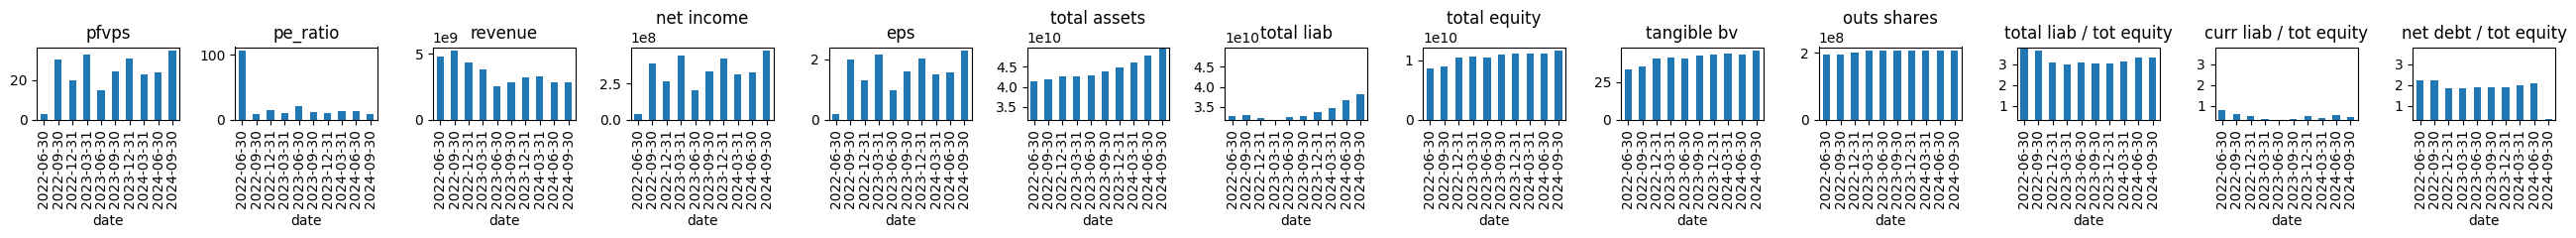

  6%|▌         | 1/18 [00:10<02:53, 10.20s/it]

ESEA.	 Current price: 38.67.	 Fair price: 42.76349958715119


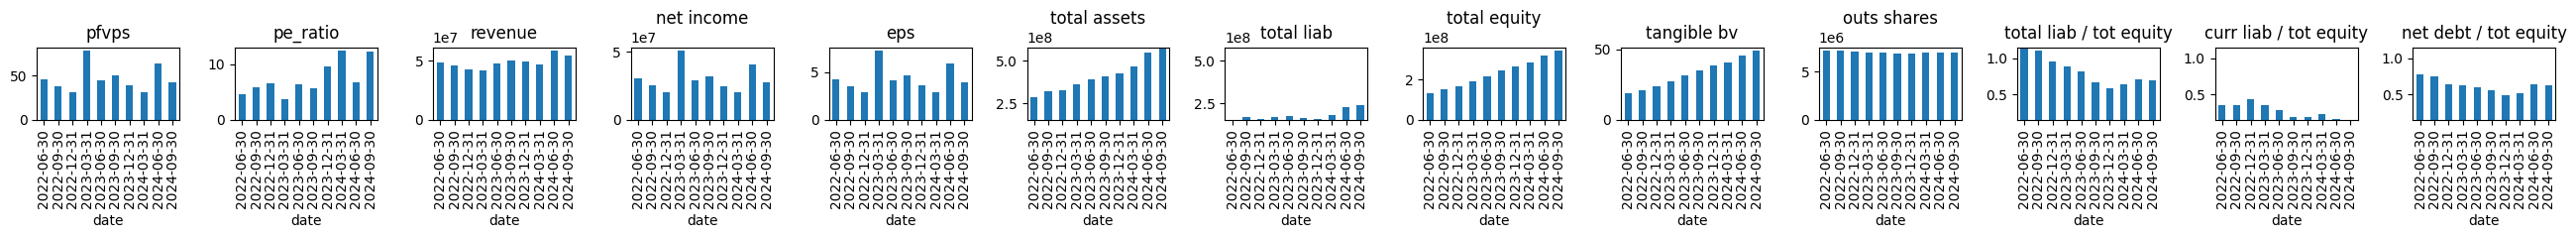

 11%|█         | 2/18 [00:21<02:54, 10.91s/it]

TYOYY.	 Current price: 54.18.	 Fair price: 266.03992079990854


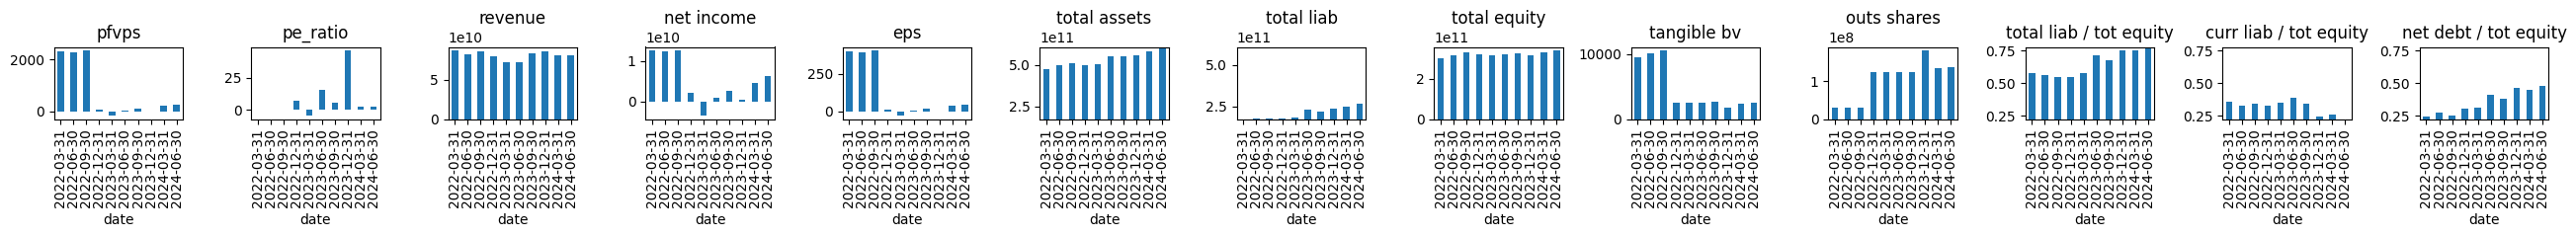

 17%|█▋        | 3/18 [00:31<02:38, 10.55s/it]

FMOCF overvalued. price: 10.6065, pfvps: 4.4582809392911065


 22%|██▏       | 4/18 [00:38<02:04,  8.86s/it]

MAHMF overvalued. price: 35.6, pfvps: 24.54739848517114


 28%|██▊       | 5/18 [00:43<01:40,  7.71s/it]

RTTNY, negative growth


 33%|███▎      | 6/18 [00:45<01:08,  5.68s/it]

BYDIF.	 Current price: 4.29.	 Fair price: 5.2529773671977775


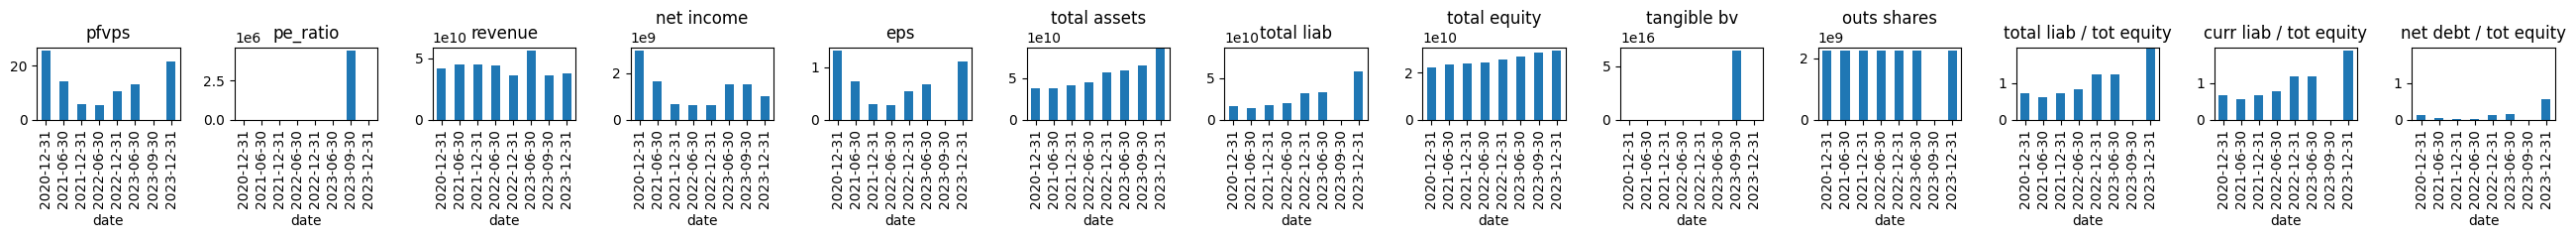

 39%|███▉      | 7/18 [00:55<01:17,  7.05s/it]

CAOVF.	 Current price: 1.65.	 Fair price: 1.9511352923128735


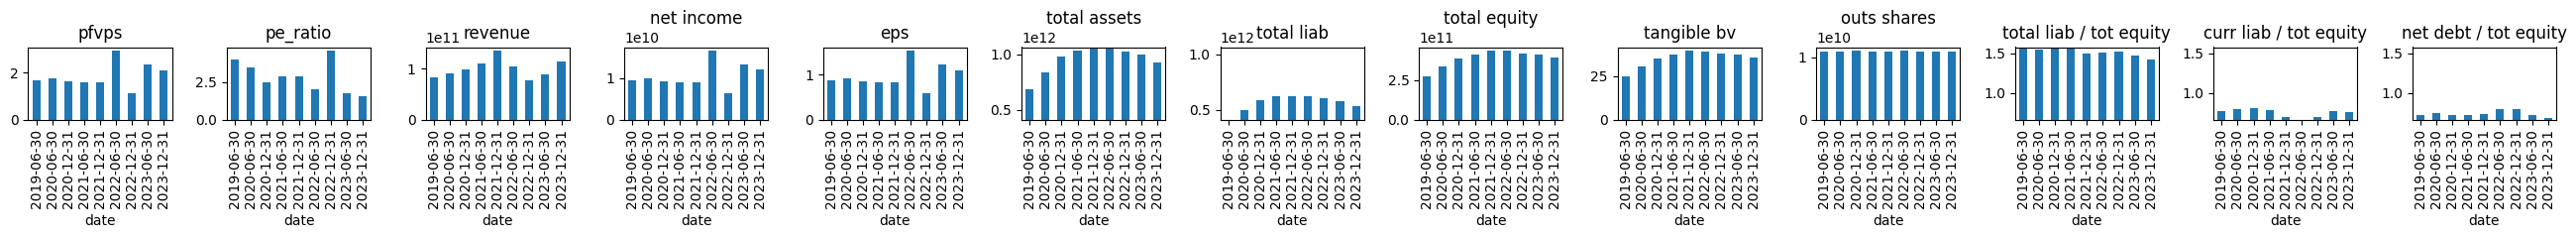

 44%|████▍     | 8/18 [01:05<01:20,  8.09s/it]

SYT overvalued. price: 1.69, pfvps: -0.41101164898295345


 50%|█████     | 9/18 [01:10<01:02,  6.97s/it]

BAYAR, negative growth


 56%|█████▌    | 10/18 [01:11<00:42,  5.35s/it]

HHR.	 Current price: 15.03.	 Fair price: 72.47010003061735


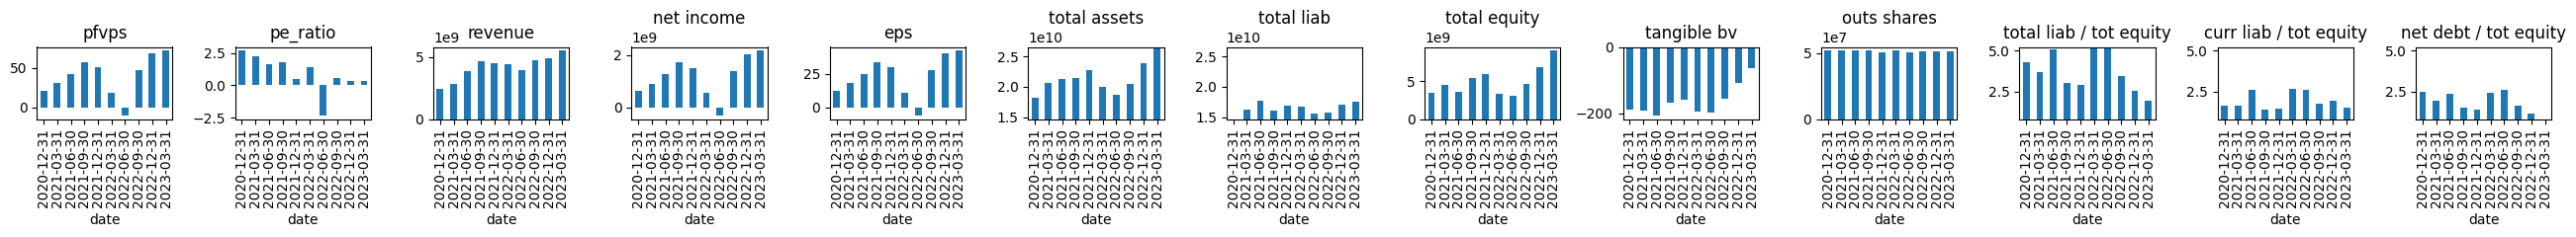

 61%|██████    | 11/18 [01:22<00:47,  6.85s/it]

SWGHF.	 Current price: 13.4.	 Fair price: 106.85620761687245


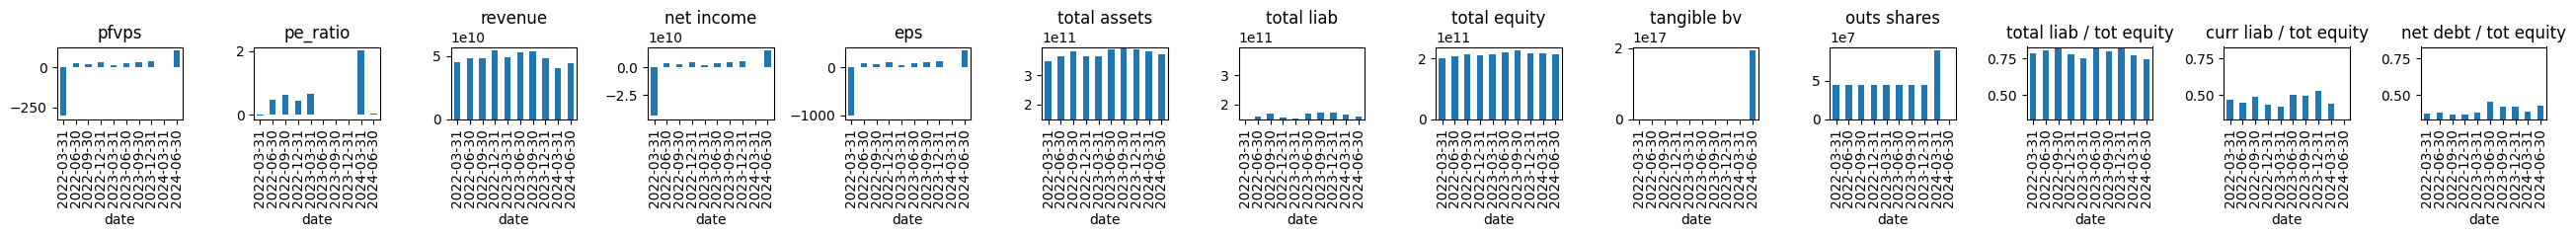

 67%|██████▋   | 12/18 [01:32<00:48,  8.06s/it]

SNTX.	 Current price: 0.0014.	 Fair price: 0.0029403360576109715


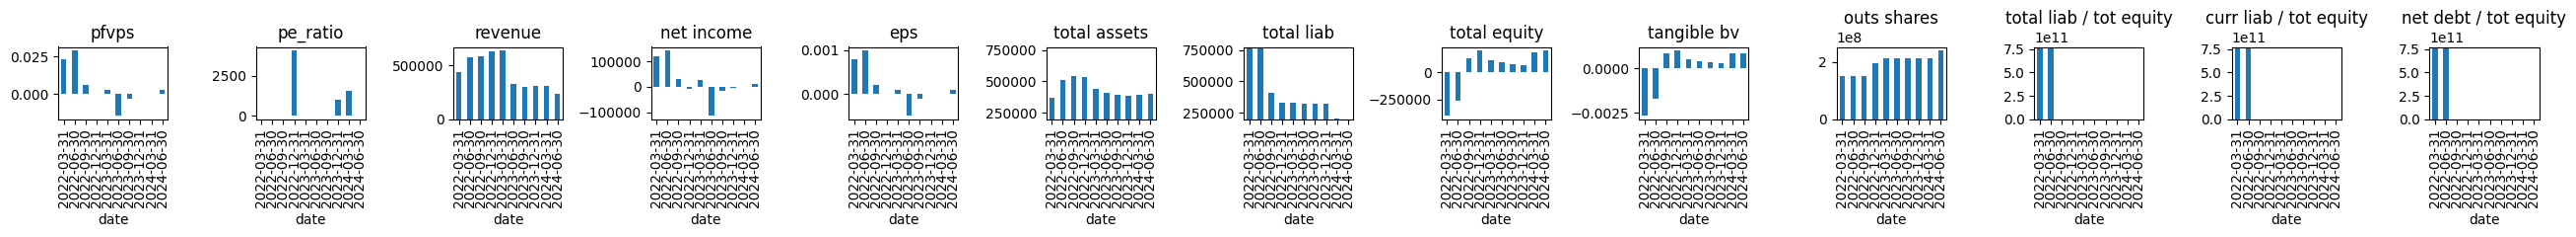

 72%|███████▏  | 13/18 [01:43<00:44,  8.86s/it]

FBBPF.	 Current price: 2.95.	 Fair price: 23.115584024265228


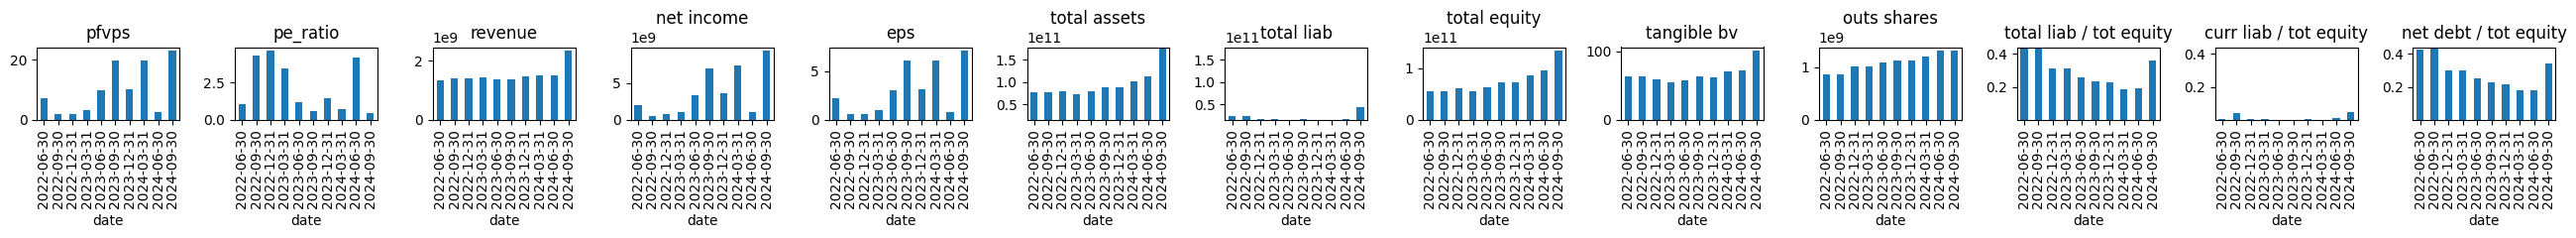

 78%|███████▊  | 14/18 [01:55<00:39,  9.75s/it]

PMTYF.	 Current price: 0.082.	 Fair price: 0.14458396016863917


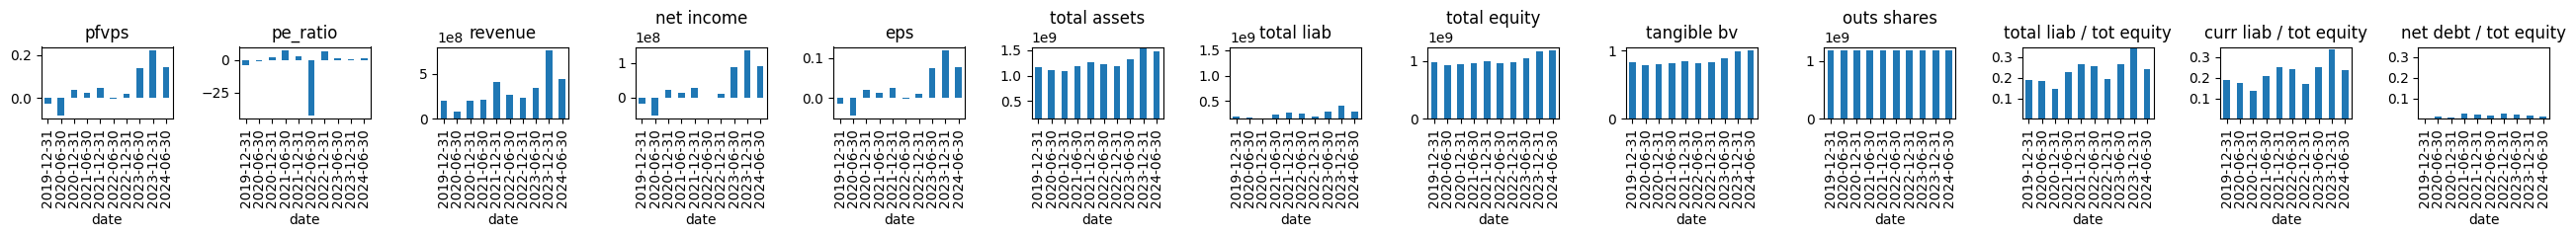

 83%|████████▎ | 15/18 [02:05<00:29,  9.80s/it]

NYWKF overvalued. price: 0.8252, pfvps: 0.0


 89%|████████▉ | 16/18 [02:11<00:17,  8.55s/it]

NBLWF.	 Current price: 0.25.	 Fair price: 0.5504869788144932


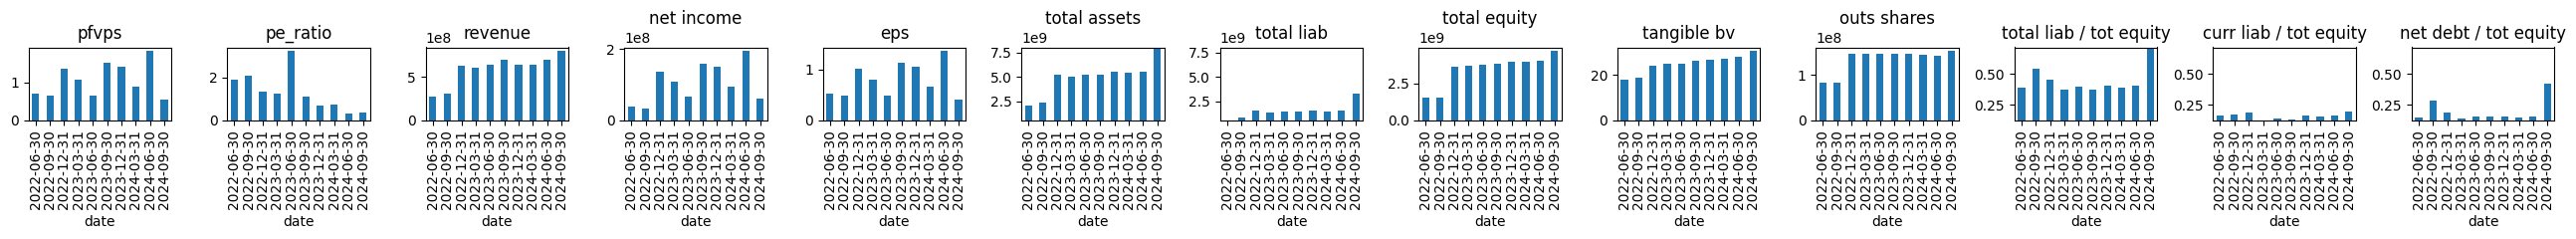

 94%|█████████▍| 17/18 [02:21<00:09,  9.03s/it]

SAPMD, only negative pe in history


100%|██████████| 18/18 [02:27<00:00,  8.18s/it]


In [8]:
missing_tickers = []
overvalued_tickers = []
#for ticker in tqdm(TICKERS[616:]):
# for ticker in tqdm(["INTC"]):
for ticker in tqdm(candidates):
    data_income_stmt = get_income_stmt_info(ticker=ticker, period="quarter", limit=10)
    data_balance_sheet = get_balance_sheet_info(ticker=ticker, period="quarter", limit=10)
    #print("after bs & is")
    #print(len(data_income_stmt), len(data_balance_sheet))
    if len(data_balance_sheet) == 0 or len(data_income_stmt) == 0:
        print(f"{ticker}, length equals zero")
        missing_tickers.append(ticker)
        
    if len(data_balance_sheet) < 5 or len(data_income_stmt) < 5:
        print(f"{ticker}, less than 5 reports")
        time.sleep(1)
        continue
    #print("after check of length of bs & is")
    balance_sheet_df = pd.DataFrame(data_balance_sheet)
    income_stmt_df = pd.DataFrame(data_income_stmt)
    balance_sheet_df = balance_sheet_df.set_index("date")
    income_stmt_df = income_stmt_df.set_index("date")
    balance_sheet_df = balance_sheet_df[bs_cols]
    income_stmt_df = income_stmt_df[is_cols]
    balance_sheet_df = balance_sheet_df.rename(columns={"fillingDate":"fillingDateBalanceSheet"})
    
    # get equity & compute growth
    all_equity = get_key_from_iterator(iterator=data_balance_sheet, key="totalStockholdersEquity")
    growths = []
    #print(all_equity)
    for nb_years in range(5, len(all_equity)+1):#6, 7, 8, 9]:
        single_growth = compute_growth(all_equity[0], all_equity[nb_years-1], nb_years-1)
        #print(nb_years, single_growth)
        #single_growth = (all_equity[0] / (all_equity[nb_years-1] + 0.001)) ** (1/(nb_years-1)) - 1
        growths.append(single_growth)
    growth_value = np.median(growths)
    #print(growths)
    if growth_value < 0: # not focusing on companies having historical negative growth_rate
        print(f"{ticker}, negative growth")
        time.sleep(1)
        continue
    # compute future pe ratio
    all_prices = []
    for single_income_stmt in data_income_stmt:
        reporting_start, reporting_end, filling_date_flag = get_reporting_window(single_income_stmt)
        data_prices = get_prices_in_range(ticker, reporting_start, reporting_end)
        try:
            range_price_lows = get_key_from_iterator(data_prices["historical"], "low")
            avg_price_at_report = compute_avg_value(range_price_lows)
        except:
            avg_price_at_report = 0
        all_prices.append(avg_price_at_report)
        
    all_eps = get_key_from_iterator(iterator=data_income_stmt, key="eps")
    all_eps = [val if val != 0 else 1e-6 for val in all_eps]
    historical_pe = list(np.array(all_prices) / np.array(all_eps))
    historical_pe = handling_negative_vals(historical_pe)
    future_pe = compute_avg_value(historical_pe)
    
    if future_pe <= 0:
        print(f"{ticker}, only negative pe in history")
        time.sleep(1)
        continue
    # compute present faire value
    #print(growth_value, return_value, future_pe, years)
    pfvps = compute_pex_value(data_income_stmt[0], growth_value, return_value, future_pe, years, quarters)
    
    # get current price
    current_price = get_current_price(ticker)
    
    # filter out companies with price > fpv
    if current_price is None or current_price > pfvps:
        print(f"{ticker} overvalued. price: {current_price}, pfvps: {pfvps}")
        overvalued_tickers.append(ticker)
        time.sleep(1)
        continue
    # compute stuff to plot
    try:
        fs_df = pd.concat([balance_sheet_df, income_stmt_df], axis=1, join="inner")
    except:
        print(f"{ticker}, dates incoherence")
        continue
    fs_df = fs_df.iloc[::-1] # from oldest to newest
    # compute PFV
    fs_df["pfvps"] = fs_df.apply(compute_pex_value, args=(growth_value, return_value, future_pe, years, quarters), axis=1)
    # compute tangible book value per share
    fs_df["tangible_book_value_ps"] = fs_df.apply(compute_tangible_book_value_ps, axis=1)
    # compute discounted tangible book value per share
    #fs_df["dct_tangible_book_value_ps"] = fs_df.apply(compute_discounted_tangible_book_value_ps, args=(current_assets_factors, ), axis=1)
    # compute current ratio
    #fs_df["current_ratio"] = fs_df.apply(compute_current_ratio, axis=1)
    # get price at report date
    fs_df["reporting_date_price"] = None
    windows = fs_df.reset_index().apply(get_reporting_window, axis=1)
    window_df = pd.DataFrame(windows, columns=["iter"])
    del windows
    window_df = pd.DataFrame(
        window_df.iter.tolist(),
        columns=["report_start", "report_end", "filling_date_bool"],
        index=fs_df.index,
    )
    window_df["prices"] = None
    for idx, row in window_df.iterrows():
        window_df.at[idx, "prices"] = get_prices_in_range(
            ticker, window_df.loc[idx, "report_start"], window_df.loc[idx, "report_end"],
        )
    window_df["prices"] = window_df["prices"].apply(get_price_history)
    fs_df["reporting_date_price"] = None
    for idx, row in window_df.iterrows():
        fs_df.at[idx, "reporting_date_price"] = compute_price_at_reporting_date(
            window_df.loc[idx, "prices"], window_df.loc[idx, "filling_date_bool"], "low",
        )
    del window_df
    #pd.Series(fs_df.reset_index().apply(compute_price_at_reporting_date, args=(filling_date_flag, "low"), axis=1), index=fs_df.index) # <- REVIEW THIS LINE
    # compute pe ratio
    fs_df["pe_ratio"] = fs_df.apply(compute_pe_ratio, axis=1)
    # compute de ratio 1
    fs_df["de_ratio1"] = fs_df.apply(compute_de_ratio, args=("totalLiabilities",), axis=1)
    # compute de ratio 2
    fs_df["de_ratio2"] = fs_df.apply(compute_de_ratio, args=("totalCurrentLiabilities",), axis=1)
    # compute de ratio 3
    fs_df["de_ratio3"] = fs_df.apply(compute_de_ratio, args=("totalDebt",), axis=1)
    #print(fs_df)
    # plot indicators
    print(f"{ticker}.\t Current price: {current_price}.\t Fair price: {pfvps}")
    plot_indicators_epsx(fs_df)

    time.sleep(1)

In [6]:
from sqlalchemy.pool import QueuePool

In [7]:
injector = Injector()
engine = create_engine(
    injector.db_uri, poolclass=QueuePool, pool_size=10, max_overflow=20
)
with engine.connect() as connection:
    df = pd.read_sql(
        """select * from financial_stmts where symbol_bs = 'PHNGF'""", connection
    )

ValueError: invalid literal for int() with base 10: 'None'